In [23]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [33]:
image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti", use_fast=True)
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti")

In [29]:
image = Image.open("../data/a3.jpg")
# new_height = 480 if image.height > 480 else image.height
# new_height -= (new_height % 32)
# new_width = int(new_height * image.width / image.height)
# diff = new_width % 32
# new_width = new_width - diff if diff < 16 else new_width + 32 - diff
# new_size = (new_width, new_height)
# image = image.resize(new_size)

In [34]:
inputs = image_processor(images=image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    # predicted_depth = outputs.predicted_depth

In [42]:
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    source_sizes=[(image.height, image.width)],
)

# visualize the prediction
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = predicted_depth * 255 / predicted_depth.max()
depth = depth.detach().cpu().numpy()
depth = depth.astype("uint8")

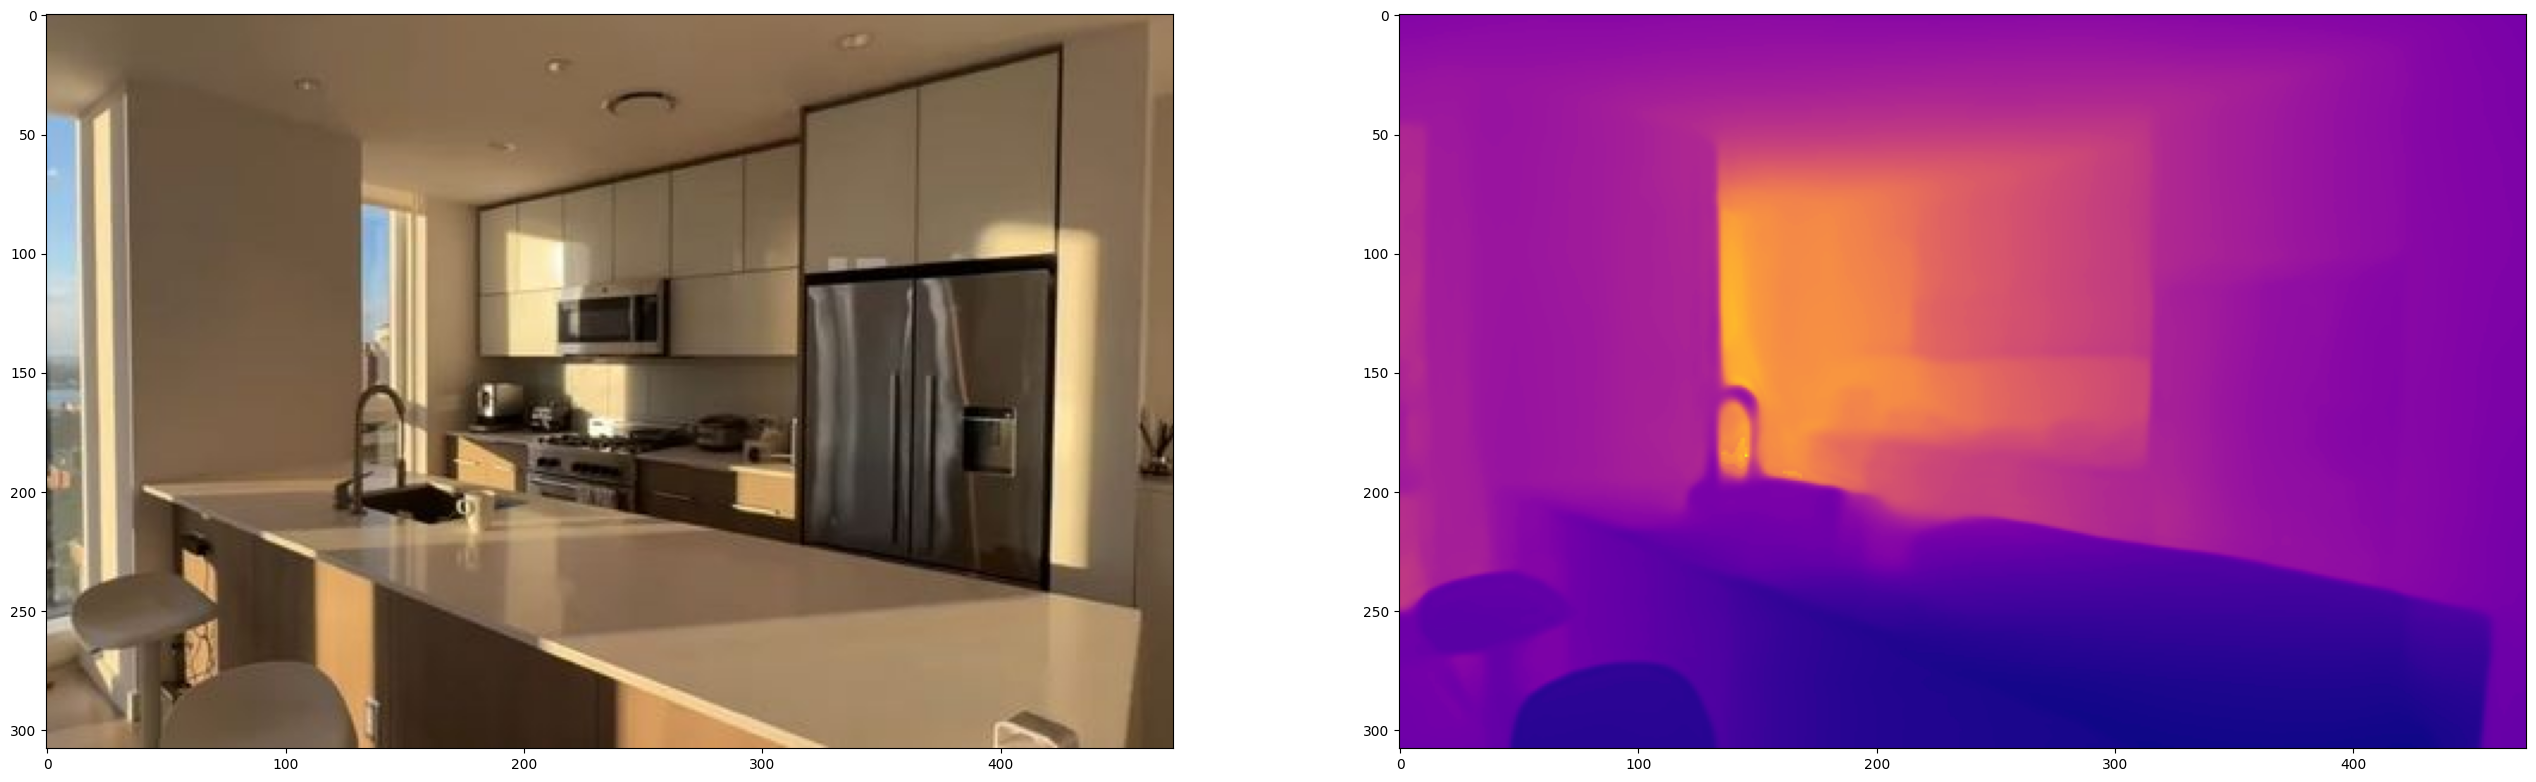

In [43]:
# pad = 16
# output = predicted_depth.squeeze().cpu().numpy() * 1000.0
# output = output[pad:-pad, pad:-pad]
# img = image.crop((pad, pad, image.width - pad, image.height - pad))

fig, ax = plt.subplots(1, 2, figsize=(32, 16))
ax[0].imshow(image)
ax[1].imshow(depth, cmap="plasma")

In [44]:
depth

array([[92, 92, 92, ..., 85, 85, 85],
       [92, 92, 92, ..., 85, 85, 85],
       [93, 93, 93, ..., 85, 85, 85],
       ...,
       [79, 79, 79, ..., 76, 76, 76],
       [79, 79, 79, ..., 76, 76, 77],
       [79, 79, 79, ..., 76, 76, 77]], dtype=uint8)

In [46]:
w, h = image.size
# depth_image = (output * 255 / np.max(output)).astype('uint8')

depth_o3d = o3d.geometry.Image(depth)
image_o3d = o3d.geometry.Image(np.array(image))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

In [47]:
cam_intrinsic = o3d.camera.PinholeCameraIntrinsic()
cam_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)

In [48]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam_intrinsic)

o3d.visualization.draw_geometries([pcd])

In [52]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0, print_progress=True)
pcd_filt = pcd.select_by_index(ind)

pcd_filt.estimate_normals()
pcd_filt.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd_filt])

# Point Cloud to Mesh

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_filt, depth=8)[0]

rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0,0,0))

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [14]:
mesh_uniform = mesh.paint_uniform_color([0.9, 0.8, 0.9])
mesh_uniform.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_uniform], mesh_show_back_face=True)

In [ ]:
o3d.io.write_triangle_mesh("../results/scuffed.obj", mesh) #.ply for color